# Movie Ratings Predictor

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # For training and test splits
from sklearn.linear_model import LinearRegression #for linear regression
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as glm #for generalised linear models
from statsmodels.stats.outliers_influence import variance_inflation_factor# Calculates multicollinearity (VIF) for regression models
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import joblib # For saving and loading models efficiently.


glm.SET_USE_BIC_LLF = True #  to enable the use of the Bayesian Information Criterion (BIC) in GLM.

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_film_tv_movies = pd.read_csv("INPUT/filmtv_movies.csv")
df_film_tv_movies.shape

(41399, 19)

In [3]:
# Remove duplicate movie titles to ensure unique records
df_film_tv_movies = df_film_tv_movies.drop_duplicates(subset='title')
df_film_tv_movies.shape

(39531, 19)

After removing duplicates based on title, it reduced from 41,399 rows, which suggests about 1,868 duplicates were dropped.

In [4]:
df_film_tv_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39531 entries, 0 to 41398
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filmtv_id     39531 non-null  int64  
 1   title         39531 non-null  object 
 2   year          39531 non-null  int64  
 3   genre         39441 non-null  object 
 4   duration      39531 non-null  int64  
 5   country       39521 non-null  object 
 6   directors     39502 non-null  object 
 7   actors        37467 non-null  object 
 8   avg_vote      39531 non-null  float64
 9   critics_vote  35095 non-null  float64
 10  public_vote   39346 non-null  float64
 11  total_votes   39531 non-null  int64  
 12  description   38061 non-null  object 
 13  notes         18007 non-null  object 
 14  humor         39531 non-null  int64  
 15  rhythm        39531 non-null  int64  
 16  effort        39531 non-null  int64  
 17  tension       39531 non-null  int64  
 18  erotism       39531 non-null  i

In [114]:
df_film_tv_movies.head(5)

,filmtv_id,title,year,genre,duration,country,directors,actors,avg_vote,critics_vote,public_vote,total_votes,description,notes,humor,rhythm,effort,tension,erotism
0,2,Bugs Bunny's Third Movie: 1001 Rabbit Tales,1982,Animation,76,United States,"David Detiege, Art Davis, Bill Perez",NaN,7.7,8.00,7.0,22,"With two protruding front teeth, a slightly sl...","These are many small independent stories, whic...",3,3,0,0,0
1,3,18 anni tra una settimana,1991,Drama,98,Italy,Luigi Perelli,"Kim Rossi Stuart, Simona Cavallari, Ennio Fant...",6.5,6.00,7.0,4,"Samantha, not yet eighteen, leaves the comfort...","Luigi Perelli, the director of the ""Piovra"", o...",0,2,0,2,0
2,17,Ride a Wild Pony,1976,Romantic,91,United States,Don Chaffey,"Michael Craig, John Meillon, Eva Griffith, Gra...",5.7,6.00,5.0,10,"In the Australia of the pioneers, a boy and a ...","""Ecological"" story with a happy ending, not wi...",1,2,1,0,0
3,18,Diner,1982,Comedy,95,United States,Barry Levinson,"Mickey Rourke, Steve Guttenberg, Ellen Barkin,...",7.0,8.00,6.0,18,Five boys from Baltimore have a habit of meeti...,A cast of will be famous for Levinson's direct...,2,2,0,1,2
4,20,A che servono questi quattrini?,1942,Comedy,85,Italy,Esodo Pratelli,"Eduardo De Filippo, Peppino De Filippo, Clelia...",5.9,5.33,7.0,15,"With a stratagem, the penniless and somewhat p...",Taken from the play by Armando Curcio that the...,3,1,1,0,0


Key columns include:
- title, year, genre, duration, country, directors, actors: Descriptive and categorical data.
- avg_vote, critics_vote, public_vote: Numerical ratings.
- humor, rhythm, effort, tension, erotism: Additional numerical measures.


- Ratings (avg_vote, critics_vote, public_vote) can be used for modeling or comparisons.
- Text columns like description or notes for NLP-based analysis.

Data Types:
- Most columns are int64 or float64 (numerical data).
- object types for text fields like title, genre, country, directors, etc.

Missing Data:
- Notable columns with missing values:
- genre: 90 missing rows.
- country: 10 missing rows.
- directors: 29 missing rows.
- actors: 2,064 missing rows.
- critics_vote: 4,436 missing rows.
- public_vote: 185 missing rows.
- description: 1,470 missing rows.
- notes: Heavily missing (only ~45% non-null).

## Target Definition

Predict the critique ratings, then transform it to rotten tomatoes ratings:
- Certified Fresh (Score: 8+)
- Fresh (Score: 6-8)
- Rotten (Score: <6)

## Function List

In [6]:
# Define Certified Fresh, Fresh, and Rotten, ### Classify Rotten Tomatoes ratings based on critic scores
def determine_tomato_status(row):
    if row['critics_vote'] >= 8:
        return 'Certified Fresh'
    elif row['critics_vote'] >= 6:
        return 'Fresh'
    else:
        return 'Rotten'



def model_summary(model_1, model_2, model_name, feature_name, conclusion, reason, summary_df=None): 
    """
    Appends the summary of a GLM or OLS model to a DataFrame with the RMSE difference compared to a benchmark model.

    Parameters:
    - model_1: The current fitted GLM or OLS model.
    - model_2: The benchmark GLM or OLS model.
    - model_name: A string representing the name of the model (e.g., 'GLM 0').
    - feature_name: A string that contains the selection of features.
    - conclusion: Model selection conclusion (accept or reject).
    - reason: Reason for the conclusion.
    - summary_df: An existing DataFrame to append to (default: None, creates a new one).

    Returns:
    - A DataFrame containing the model summaries.
    """

    def calculate_rmse(model):
        """
        This function calculates RMSE for GLM or OLS model.

        Parameters:
        - model: The fitted model.

        Returns:
        - RMSE value.
        """
        if hasattr(model, 'resid_response'):
            # GLM model
            residuals = model.resid_response
        elif hasattr(model, 'resid'):
            # OLS model
            residuals = model.resid
        else:
            raise ValueError("Model does not have residuals attribute for RMSE calculation.")
        return np.sqrt(np.mean(residuals**2))

    # Calculate RMSE for both models
    current_rmse = calculate_rmse(model_1)
    benchmark_rmse = calculate_rmse(model_2)
    
    # Compute RMSE differences
    rmse_diff = current_rmse - benchmark_rmse
    rmse_diff_pc = None
    if benchmark_rmse != 0:
        rmse_diff_pc = (rmse_diff / benchmark_rmse) * 100

    rmse_diff_pc_str = f"{rmse_diff_pc:.2f}%" if rmse_diff_pc is not None else None

    # Extract metrics
    model_metrics = {
        "Model": model_name,
        "Feature": feature_name,
        "AIC": model_1.aic,
        "BIC": model_1.bic,
        "RMSE": current_rmse,
        "ΔRMSE": rmse_diff,
        "ΔRMSE%": rmse_diff_pc_str,
        "Conclusion": conclusion,
        "Reason": reason
    }

    # Initialize or update the summary DataFrame
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["Model", "Feature", "AIC", "BIC", "RMSE", "ΔRMSE", "ΔRMSE%", "Conclusion", "Reason"])

    # Append the new model metrics to the summary DataFrame
    summary_df = pd.concat([summary_df, pd.DataFrame([model_metrics])], ignore_index=True)

    return summary_df


def cross_validate_glm(formula, data, family, k=5):
    """
    Perform k-fold cross-validation for a GLM model.
    
    Parameters:
    - formula: The formula for the GLM model.
    - data: The dataset to use for cross-validation.
    - family: The family for the GLM (e.g., sm.families.Gaussian()).
    - k: The number of folds for cross-validation (default: 5).
    
    Returns:
    - A dictionary with mean RMSE, individual RMSEs, and fitted models for each fold.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    rmse_scores = []
    fold_models = []
    
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Fit the GLM model on training data
        model = sm.GLM.from_formula(formula, data=train_data, family=family).fit()
        
        # Predict on the test data
        predictions = model.predict(test_data)
        
        # Calculate RMSE for the fold
        fold_rmse = np.sqrt(mean_squared_error(test_data['critics_vote'], predictions))
        rmse_scores.append(fold_rmse)
        fold_models.append(model)
    
    # Return mean RMSE, all RMSEs, and the models
    return {
        "mean_rmse": np.mean(rmse_scores),
        "rmse_scores": rmse_scores,
        "models": fold_models
    }


## Initial Feature Selection

In [7]:
df_film = df_film_tv_movies.copy() # Create a copy of the dataset to preserve the original
df_film = df_film.drop(columns=['description', 'notes', 'filmtv_id', 'title'])

Here, we are removing the columns which are not likely to contribute to the numerical modeling process.
- `description` and `notes` are only applicable to NLP based project. Since we're not building an NLP based model, we are dropping these columns.
- `filmtv_id` is an unique identifier
- `title`: Not useful for numerical modeling

In [8]:
print(df_film.columns)

Index(['year', 'genre', 'duration', 'country', 'directors', 'actors',
       'avg_vote', 'critics_vote', 'public_vote', 'total_votes', 'humor',
       'rhythm', 'effort', 'tension', 'erotism'],
      dtype='object')


In [9]:
### Checking for missing values
print(df_film.isnull().sum())

year               0
genre             90
duration           0
country           10
directors         29
actors          2064
avg_vote           0
critics_vote    4436
public_vote      185
total_votes        0
humor              0
rhythm             0
effort             0
tension            0
erotism            0
dtype: int64


## Imputation and Correlation Analysis

### Missingness

Missing Values per Column:
genre             90
country           10
directors         29
actors          2064
critics_vote    4436
public_vote      185
dtype: int64


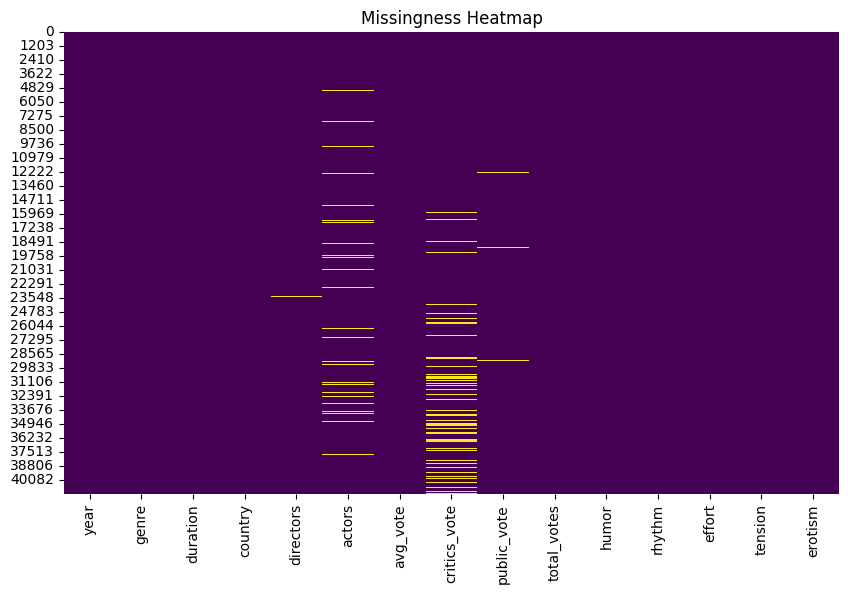


Percentage of Missing Values per Column:
critics_vote    11.221573
actors           5.221219
public_vote      0.467987
genre            0.227669
directors        0.073360
country          0.025297
dtype: float64


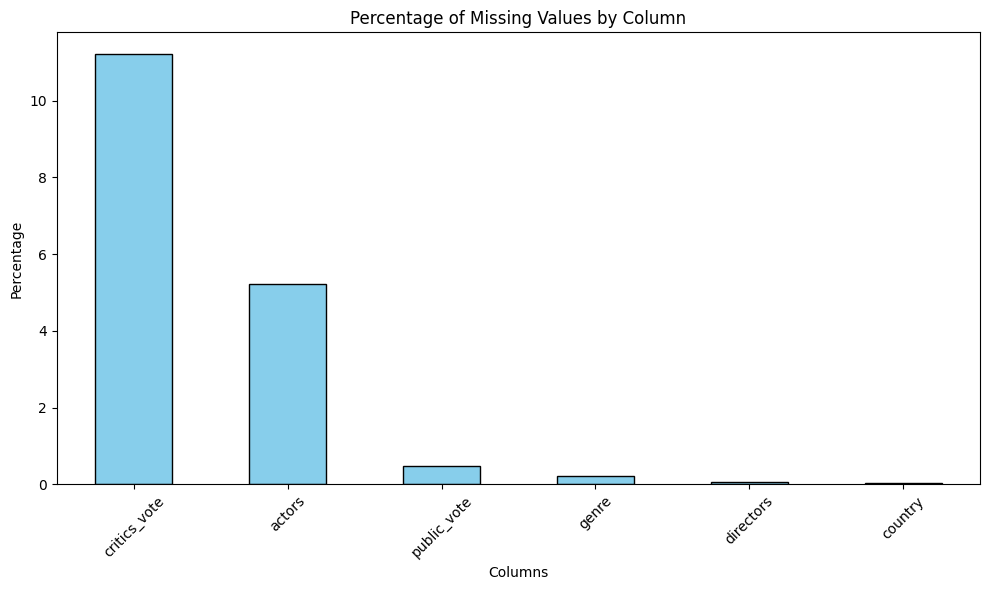

In [10]:
# Check for missing values in each column
missing_values = df_film.isnull().sum()

# Display missing value counts
print("Missing Values per Column:")
print(missing_values[missing_values > 0])

# Heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df_film.isnull(), cbar=False, cmap='viridis')
plt.title('Missingness Heatmap')
plt.show()

# Percentage of missing values
missing_percentage = (df_film.isnull().mean() * 100).sort_values(ascending=False)

# Display missingness percentage
print("\nPercentage of Missing Values per Column:")
print(missing_percentage[missing_percentage > 0])

# Plot the percentage of missing values
plt.figure(figsize=(10, 6))
missing_percentage[missing_percentage > 0].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Linear Model Imputation

#### Correlation Analysis

In [11]:
vote_variable_set = ['avg_vote', 'public_vote', 'total_votes', 'critics_vote']
df_vote = df_film[vote_variable_set]
vote_corr_matrix = df_vote.corr() #This matrix contains the correlation between the variables which helps to quantify the relationship between them   

print("Correlation matrix:")
print(vote_corr_matrix)

Correlation matrix:
              avg_vote  public_vote  total_votes  critics_vote
avg_vote      1.000000     0.893057     0.256838      0.916147
public_vote   0.893057     1.000000     0.214977      0.622646
total_votes   0.256838     0.214977     1.000000      0.238559
critics_vote  0.916147     0.622646     0.238559      1.000000


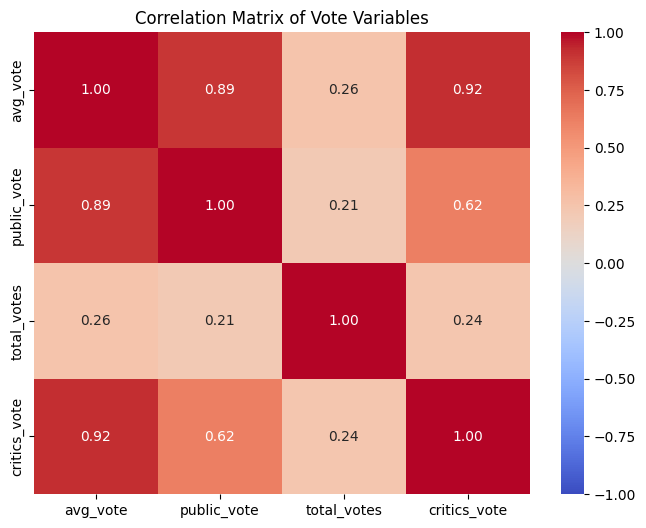

In [12]:
# Visualizing the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(vote_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Vote Variables")
plt.show()

Our interpretations are as follows:
- public_votes and average_votes correlates are highly with critics_votes
- total_votes have some correlation with critics votes

In [13]:
# Create a missingness indicator for critics_vote
df_film['critics_vote_missing'] = df_film['critics_vote'].isnull().astype(int)

# Compare avg_vote between rows with and without missing critics_vote
from scipy.stats import ttest_ind
missing_group = df_film[df_film['critics_vote_missing'] == 1]['avg_vote']
non_missing_group = df_film[df_film['critics_vote_missing'] == 0]['avg_vote']

t_stat, p_val = ttest_ind(missing_group.dropna(), non_missing_group.dropna(), equal_var=False)
print(f"T-test p-value for avg_vote: {p_val}")

T-test p-value for avg_vote: 3.1797856733374936e-264


In [14]:
# Define the independent variables (exclude critics_vote, the dependent variable)
independent_vars = ['avg_vote', 'public_vote', 'total_votes']
df_vote_cleaned = df_vote[independent_vars].dropna()  # Drop rows with NaNs

# Check for infinities and filter them out
df_vote_cleaned = df_vote_cleaned.replace([float('inf'), float('-inf')], float('nan')).dropna()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data['Variable'] = df_vote_cleaned.columns
vif_data['VIF'] = [variance_inflation_factor(df_vote_cleaned.values, i) for i in range(df_vote_cleaned.shape[1])]

print("Variance Inflation Factor (VIF) for Independent Variables:")
print(vif_data)

Variance Inflation Factor (VIF) for Independent Variables:
      Variable        VIF
0     avg_vote  82.837000
1  public_vote  81.904227
2  total_votes   1.355773


There is a high correlation between predictor variables which indicates possibility of multi-collinearity. However, since multi-collinearity only affects the model stability and interpretation, we can safely use the features for imputation purposes.

#### Critics Vote

In [15]:
# Prepare data for critics_vote
non_missing_critics_vote = df_film[df_film['critics_vote'].notnull()] ##subset where critics_votes is not null
missing_critics_vote = df_film[df_film['critics_vote'].isnull()] ##subset where critics_votes is null

# Preparing features (X) and target (y) for training the linear regression model
X_critics_vote = non_missing_critics_vote[['avg_vote', 'public_vote', 'total_votes']].dropna()  # Features
y_critics_vote = non_missing_critics_vote.loc[X_critics_vote.index, 'critics_vote']  # Target

# Drop NaNs in X_missing_critics_vote
X_missing_critics_vote = missing_critics_vote[['avg_vote', 'public_vote', 'total_votes']].dropna()

# Train model to predict critics vote
model_critics_vote = LinearRegression()
model_critics_vote.fit(X_critics_vote, y_critics_vote)

# Predict missing values
df_film.loc[X_missing_critics_vote.index, 'critics_vote'] = model_critics_vote.predict(X_missing_critics_vote)

#### Public Vote

In [16]:
# Prepare data for public_vote
non_missing_public_vote = df_film[df_film['public_vote'].notnull()]
missing_public_vote = df_film[df_film['public_vote'].isnull()]

X_public_vote = non_missing_public_vote[['avg_vote', 'critics_vote', 'total_votes']].dropna()  # Features
y_public_vote = non_missing_public_vote.loc[X_public_vote.index, 'public_vote']  # Target

# Drop NaNs in X_missing_public_vote
X_missing_public_vote = missing_public_vote[['avg_vote', 'critics_vote', 'total_votes']].dropna()

# Train model
model_public_vote = LinearRegression()
model_public_vote.fit(X_public_vote, y_public_vote)

# Predict missing values
df_film.loc[X_missing_public_vote.index, 'public_vote'] = model_public_vote.predict(X_missing_public_vote)

In [17]:
print(non_missing_public_vote.shape, missing_public_vote.shape)
print(df_film['public_vote'].isnull().sum())

(39346, 16) (185, 16)
0


## Simple Imputation

The rest of variables, which is actors, directors, genre, and country will be imputed by using ‘unknown’ values. The reason for this simple imputation instead of excluding the row since the other variables might still useful. Also, setting it to ‘unknown’ will ensure that we indicate clearly that the data is missing which maintains the interpretability.

#### Actors

In [18]:
df_film['actors'] = df_film['actors'].fillna('Unknown')

### Directors

In [19]:
df_film['directors'] = df_film['directors'].fillna('Unknown')

### Genre

In [20]:
df_film['genre'] = df_film['genre'].fillna('Unknown')

### Country

In [21]:
df_film['country'] = df_film['country'].fillna('Unknown')

In [22]:
print(df_film[['actors', 'directors', 'genre', 'country']].isnull().sum())

actors       0
directors    0
genre        0
country      0
dtype: int64


## Train-Test Split

In [23]:
#Seperating features and target
X = df_film.drop(columns='critics_vote')  # Features
y = df_film['critics_vote']  # Target

#Splits the dataset into training (80%) and testing (20%) subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Combining features and target for training and testing datasets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [24]:
print(f"Training set size: {train_data.shape[0]}")
print(f"Testing set size: {test_data.shape[0]}")

Training set size: 31624
Testing set size: 7907


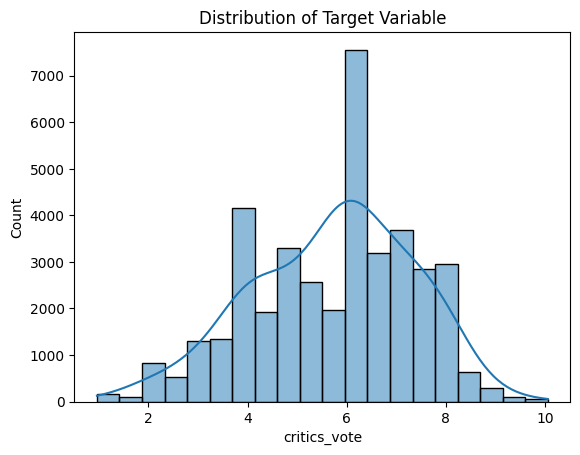

In [25]:
sns.histplot(y, kde=True, bins=20, kde_kws={'bw_adjust': 3})
plt.title('Distribution of Target Variable')
plt.show()

## Data Analysis

### Data Explosion

In [26]:
# Reset the index to ensure consistency
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#### Actors

Exploding the train data

In [27]:
# Split actors into a list of individual actors
train_data['actors_list'] = train_data['actors'].apply(lambda x: str(x).split(', '))

# Explode the actors_list into individual rows
df_actors_exploded = train_data.explode('actors_list')

# Group by actor and calculate number of appearances and average critics_vote
actor_stats = df_actors_exploded.groupby('actors_list').agg(
    num_appearances=('actors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
actor_stats = actor_stats.sort_values(by='num_appearances', ascending=False)

Exploding the test data

In [28]:
# Split actors into a list
test_data['actors_list'] = test_data['actors'].apply(lambda x: str(x).split(', '))

# Explode the actors_list into individual rows
df_actors_exploded_test = test_data.explode('actors_list')

# Group by actor and calculate number of appearances and average critics_vote
actor_stats_test = df_actors_exploded_test.groupby('actors_list').agg(
    num_appearances=('actors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
actor_stats_test = actor_stats_test.sort_values(by='num_appearances', ascending=False)

#### Directors

Exploding the train data

In [29]:
# Split directors into a list
train_data['directors_list'] = train_data['directors'].apply(lambda x: str(x).split(', '))

# Explode the directors_list into individual rows
df_directors_exploded = train_data.explode('directors_list')

# Group by director and calculate number of appearances and average critics_vote
director_stats = df_directors_exploded.groupby('directors_list').agg(
    num_appearances=('directors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
director_stats = director_stats.sort_values(by='num_appearances', ascending=False)


Exploding the test data

In [30]:
# Split directors into a list
test_data['directors_list'] = test_data['directors'].apply(lambda x: str(x).split(', '))

# Explode the directors_list into individual rows
df_directors_exploded_test = test_data.explode('directors_list')

# Group by director and calculate number of appearances and average critics_vote
director_stats_test = df_directors_exploded_test.groupby('directors_list').agg(
    num_appearances=('directors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
director_stats_test = director_stats_test.sort_values(by='num_appearances', ascending=False)


#### Country

Exploding the train data

In [31]:
# Split countries into a list
train_data['countries_list'] = train_data['country'].apply(lambda x: str(x).split(', '))

# Explode the countries_list into individual rows
df_countries_exploded = train_data.explode('countries_list')

# Group by country and calculate number of appearances and average critics_vote
country_stats = df_countries_exploded.groupby('countries_list').agg(
    num_appearances=('countries_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
country_stats = country_stats.sort_values(by='num_appearances', ascending=False)


Exploding the test data

In [32]:
# Split countries into a list
test_data['countries_list'] = test_data['country'].apply(lambda x: str(x).split(', '))

# Explode the countries_list into individual rows
df_countries_exploded_test = test_data.explode('countries_list')

# Group by country and calculate number of appearances and average critics_vote
country_stats_test = df_countries_exploded_test.groupby('countries_list').agg(
    num_appearances=('countries_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
country_stats_test = country_stats_test.sort_values(by='num_appearances', ascending=False)


In [33]:
print(f"Original train_data shape: {train_data.shape}")
print(f"Exploded df_countries_exploded shape: {df_countries_exploded.shape}")

Original train_data shape: (31624, 19)
Exploded df_countries_exploded shape: (38484, 19)


#### Genre

In [34]:
# Split genres into a list
train_data['genres_list'] = train_data['genre'].apply(lambda x: str(x).split(', '))

# Explode the genres_list into individual rows
df_genres_exploded = train_data.explode('genres_list')

# Group by genre and calculate number of appearances and average critics_vote
genre_stats = df_genres_exploded.groupby('genres_list').agg(
    num_appearances=('genres_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
genre_stats = genre_stats.sort_values(by='num_appearances', ascending=False)


In [35]:
# Split genres into a list
test_data['genres_list'] = test_data['genre'].apply(lambda x: str(x).split(', '))

# Explode the genres_list into individual rows
df_genres_exploded_test = test_data.explode('genres_list')

# Group by genre and calculate number of appearances and average critics_vote
genre_stats_test = df_genres_exploded_test.groupby('genres_list').agg(
    num_appearances=('genres_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
genre_stats_test = genre_stats_test.sort_values(by='num_appearances', ascending=False)

### Representation Analysis

#### Country

In [36]:
# Add representation percentage and cumulative percentage (train)
total_appearances = country_stats['num_appearances'].sum()
country_stats['representation'] = (country_stats['num_appearances'] / total_appearances) * 100

#Cumulative Percentage
country_stats['cumulative_percentage'] = country_stats['representation'].cumsum()

In [37]:
country_stats.head(15)


,countries_list,num_appearances,avg_critics_vote,representation,cumulative_percentage
151,United States,14210,5.694683,36.924436,36.924436
68,Italy,7743,5.062886,20.120050,57.044486
46,France,3565,6.277185,9.263590,66.308076
54,Great Britain,2520,6.088197,6.548176,72.856252
50,Germany,1706,5.666335,4.433011,77.289263
25,Canada,1194,5.086787,3.102588,80.391851
134,Spain,905,5.508825,2.351627,82.743478
74,Japan,806,6.664628,2.094377,84.837855
14,Belgium,295,6.222810,0.766552,85.604407
9,Australia,293,5.823814,0.761355,86.365762


#### Genres

In [38]:
# Add representation percentage and cumulative percentage
total_appearances = genre_stats['num_appearances'].sum()
genre_stats['representation'] = (genre_stats['num_appearances'] / total_appearances) * 100

#Cumulative Percentage
genre_stats['cumulative_percentage'] = genre_stats['representation'].cumsum()

In [39]:
genre_stats.head(15)

,genres_list,num_appearances,avg_critics_vote,representation,cumulative_percentage
8,Drama,9104,6.224562,28.788262,28.788262
5,Comedy,7196,5.374614,22.754870,51.543132
27,Thriller,2730,5.405278,8.632684,60.175816
14,Horror,1786,5.121750,5.647609,65.823425
0,Action,1612,4.969698,5.097394,70.920820
7,Documentary,1605,6.583750,5.075259,75.996079
1,Adventure,1173,5.329969,3.709208,79.705287
30,Western,893,5.599858,2.823805,82.529092
2,Animation,841,6.058921,2.659373,85.188464
19,Romantic,763,4.804489,2.412725,87.601189


## Feature Engineering

### Statistical Features

The statistical features created as an alternative to one-hot-encoding mainly for variables actors, directors, and genres which have high variation and potentially complicate the GLM model. The idea is to set the average score based on the exploded data, then create a dictionary to establish a bridge between exploded variables and score or frequency.  

The newly created statistical features are as follows:
- actor_frequency
- actor_avg_critics_vote
- country_frequency
- country_avg_critics_vote
- director_frequency
- director_avg_critics_vote
- genre_frequency
- genre_avg_critics_vote

#### Actors

In [40]:
# Split actors into a list
df_film['actors_list'] = df_film['actors'].apply(lambda x: str(x).split(', '))

# Explode the actors_list into individual rows
df_actors_exploded_film = df_film.explode('actors_list')

# Group by actor and calculate number of appearances and average critics_vote
actor_stats = df_actors_exploded_film.groupby('actors_list').agg(
    num_appearances=('actors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Create dictionaries for actor statistics
actor_frequency_dict = actor_stats.set_index('actors_list')['num_appearances'].to_dict()
actor_avg_vote_dict = actor_stats.set_index('actors_list')['avg_critics_vote'].to_dict()

In [41]:
# Add frequency and average critics vote to exploded DataFrame
df_actors_exploded['actor_frequency'] = df_actors_exploded['actors_list'].map(actor_frequency_dict)
df_actors_exploded['actor_avg_critics_vote'] = df_actors_exploded['actors_list'].map(actor_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_actors_aggregated = df_actors_exploded.groupby(df_actors_exploded.index).agg(
    actor_frequency=('actor_frequency', 'mean'),
    actor_avg_critics_vote=('actor_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_actors_aggregated, left_index=True, right_on='index', how='left').drop(columns='index')

In [42]:
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_actors_exploded_test['actor_frequency'] = df_actors_exploded_test['actors_list'].map(actor_frequency_dict).fillna(0)
df_actors_exploded_test['actor_avg_critics_vote'] = df_actors_exploded_test['actors_list'].map(actor_avg_vote_dict).fillna(train_data['actor_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_actors_aggregated_test = df_actors_exploded_test.groupby(df_actors_exploded_test.index).agg(
    actor_frequency=('actor_frequency', 'mean'),
    actor_avg_critics_vote=('actor_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_actors_aggregated_test, left_index=True, right_on='index', how='left').drop(columns='index')

#### Directors

In [43]:
# Split directors into a list for df_film
df_film['directors_list'] = df_film['directors'].apply(lambda x: str(x).split(', '))

# Explode the directors_list into individual rows
df_directors_exploded_film = df_film.explode('directors_list')

# Group by director and calculate number of appearances and average critics_vote
director_stats_film = df_directors_exploded_film.groupby('directors_list').agg(
    num_appearances=('directors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Create dictionaries for director statistics
director_frequency_dict = director_stats_film.set_index('directors_list')['num_appearances'].to_dict()
director_avg_vote_dict = director_stats_film.set_index('directors_list')['avg_critics_vote'].to_dict()

In [44]:
# Add frequency and average critics vote to exploded DataFrame
df_directors_exploded['director_frequency'] = df_directors_exploded['directors_list'].map(director_frequency_dict)
df_directors_exploded['director_avg_critics_vote'] = df_directors_exploded['directors_list'].map(director_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_directors_aggregated = df_directors_exploded.groupby(df_directors_exploded.index).agg(
    director_frequency=('director_frequency', 'mean'),
    director_avg_critics_vote=('director_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_directors_aggregated , left_index=True, right_on='index', how='left').drop(columns='index')

In [45]:
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_directors_exploded_test['director_frequency'] = df_directors_exploded_test['directors_list'].map(director_frequency_dict).fillna(0)
df_directors_exploded_test['director_avg_critics_vote'] = df_directors_exploded_test['directors_list'].map(director_avg_vote_dict).fillna(train_data['director_avg_critics_vote'].mean())

#Aggregate statistics back to the original DataFrame
df_directors_aggregated_test = df_directors_exploded_test.groupby(df_directors_exploded_test.index).agg(
    director_frequency=('director_frequency', 'mean'),
    director_avg_critics_vote=('director_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_directors_aggregated_test , left_index=True, right_on='index', how='left').drop(columns='index')

#### Genre

In [46]:
# Split genres into a list
df_film['genres_list'] = df_film['genre'].apply(lambda x: str(x).split(', '))

# Explode the genres_list into individual rows
df_genres_exploded_film = df_film.explode('genres_list')

# Group by genre and calculate number of appearances and average critics_vote
genre_stats = df_genres_exploded_film.groupby('genres_list').agg(
    num_appearances=('genres_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Create dictionaries
genre_frequency_dict = genre_stats.set_index('genres_list')['num_appearances'].to_dict()
genre_avg_vote_dict = genre_stats.set_index('genres_list')['avg_critics_vote'].to_dict()

In [47]:
# Add frequency and average critics vote to exploded DataFrame
df_genres_exploded['genre_frequency'] = df_genres_exploded['genres_list'].map(genre_frequency_dict)
df_genres_exploded['genre_avg_critics_vote'] = df_genres_exploded['genres_list'].map(genre_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_genres_aggregated = df_genres_exploded.groupby(level=0).agg(
    genre_frequency=('genre_frequency', 'mean'),
    genre_avg_critics_vote=('genre_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_genres_aggregated = df_genres_aggregated.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_genres_aggregated, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
train_data = train_data.drop(columns=['original_index'])

In [48]:
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_genres_exploded_test['genre_frequency'] = df_genres_exploded_test['genres_list'].map(genre_frequency_dict).fillna(0)
df_genres_exploded_test['genre_avg_critics_vote'] = df_genres_exploded_test['genres_list'].map(genre_avg_vote_dict).fillna(train_data['genre_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_genres_aggregated_test = df_genres_exploded_test.groupby(level=0).agg(
    genre_frequency=('genre_frequency', 'mean'),
    genre_avg_critics_vote=('genre_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_genres_aggregated_test = df_genres_aggregated_test.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_genres_aggregated_test, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
test_data = test_data.drop(columns=['original_index'])


#### Country

In [49]:
#### Country
# Create dictionaries
country_frequency_dict = country_stats.set_index('countries_list')['num_appearances'].to_dict()
country_avg_vote_dict = country_stats.set_index('countries_list')['avg_critics_vote'].to_dict()

# Add frequency and average critics vote to exploded DataFrame
df_countries_exploded['country_frequency'] = df_countries_exploded['countries_list'].map(country_frequency_dict)
df_countries_exploded['country_avg_critics_vote'] = df_countries_exploded['countries_list'].map(country_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_film_aggregated = df_countries_exploded.groupby(level=0).agg(
    country_frequency=('country_frequency', 'mean'),
    country_avg_critics_vote=('country_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_film_aggregated = df_film_aggregated.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_film_aggregated, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
train_data = train_data.drop(columns=['original_index'])
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_countries_exploded_test['country_frequency'] = df_countries_exploded_test['countries_list'].map(country_frequency_dict).fillna(0)
df_countries_exploded_test['country_avg_critics_vote'] = df_countries_exploded_test['countries_list'].map(country_avg_vote_dict).fillna(train_data['country_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_film_aggregated_test = df_countries_exploded_test.groupby(level=0).agg(
    country_frequency=('country_frequency', 'mean'),
    country_avg_critics_vote=('country_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_film_aggregated_test = df_film_aggregated_test.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_film_aggregated_test, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
test_data = test_data.drop(columns=['original_index'])

### Missingness Indicators

These features are created to support the 'unknown' missing data:
- IS_ACTOR_MISSING
- IS_GENRE_MISSING
- IS_COUNTRY_MISSING
- IS_DIRECTOR_MISING

These missingness indicators intended to:
- Preserve interpretability
- Prevent imputation bias
- Reduce potential noise

In [50]:
# Create binary flags for missing data
train_data['IS_ACTOR_MISSING'] = train_data['actors'].apply(lambda x: int(x == 'Unknown'))
train_data['IS_GENRE_MISSING'] = train_data['genre'].apply(lambda x: int(x == 'Unknown'))
train_data['IS_COUNTRY_MISSING'] = train_data['country'].apply(lambda x: int(x == 'Unknown'))
train_data['IS_DIRECTOR_MISSING'] = train_data['directors'].apply(lambda x: int(x == 'Unknown'))

test_data['IS_ACTOR_MISSING'] = test_data['actors'].apply(lambda x: int(x == 'Unknown'))
test_data['IS_GENRE_MISSING'] = test_data['genre'].apply(lambda x: int(x == 'Unknown'))
test_data['IS_COUNTRY_MISSING'] = test_data['country'].apply(lambda x: int(x == 'Unknown'))
test_data['IS_DIRECTOR_MISSING'] = test_data['directors'].apply(lambda x: int(x == 'Unknown'))


# Display the DataFrame to verify
print(train_data[['IS_ACTOR_MISSING', 'IS_GENRE_MISSING', 'IS_COUNTRY_MISSING', 'IS_DIRECTOR_MISSING']].head())


   IS_ACTOR_MISSING  IS_GENRE_MISSING  IS_COUNTRY_MISSING  IS_DIRECTOR_MISSING
0                 0                 0                   0                    0
1                 0                 0                   0                    0
2                 0                 0                   0                    0
3                 0                 0                   0                    0
4                 0                 0                   0                    0


### Feature Isolation

Based on representation analysis on country_stats and genre_stats (**taking 85% as threshold**), candidate for feature isolation are as follows:

- Top 8 Country 
- Top 10 Genres

These feature isolation intended to:
- Reduce model dimension for GLM
- Reduce potential for overfitting
- Feature prioritization

##### Country Isolation

In [51]:
# Identify the top 8 countries
top_countries = country_stats['countries_list'].head(8).tolist()

# Create IS_POPULAR_COUNTRY feature
train_data['IS_POPULAR_COUNTRY'] = train_data['countries_list'].apply(
    lambda countries: int(any(country in top_countries for country in countries))
)

test_data['IS_POPULAR_COUNTRY'] = test_data['countries_list'].apply(
    lambda countries: int(any(country in top_countries for country in countries))
)

In [52]:
print(top_countries)

['United States', 'Italy', 'France', 'Great Britain', 'Germany', 'Canada', 'Spain', 'Japan']


In [53]:
## Confirming the binary variables

In [54]:
print(train_data[['countries_list', 'IS_POPULAR_COUNTRY']].head())

      countries_list  IS_POPULAR_COUNTRY
0            [Spain]                   1
1    [United States]                   1
2           [France]                   1
3      [Netherlands]                   0
4  [Romania, France]                   1


In [55]:
print(test_data[['countries_list', 'IS_POPULAR_COUNTRY']].head())

    countries_list  IS_POPULAR_COUNTRY
0  [United States]                   1
1          [Italy]                   1
2  [United States]                   1
3         [France]                   1
4          [Italy]                   1


##### Genre Isolation

In [56]:
# Identify the top 10 genres
top_genres = genre_stats['genres_list'].head(10).tolist()

# Create IS_POPULAR_GENRE feature
train_data['IS_POPULAR_GENRE'] = train_data['genre'].apply(
    lambda x: int(x in top_genres)
)

test_data['IS_POPULAR_GENRE'] = test_data['genre'].apply(
    lambda x: int(x in top_genres)
)

In [57]:
print(top_genres)

['Action', 'Adventure', 'Animation', 'Biblical', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Erotico']


In [58]:
print(train_data[['genre', 'IS_POPULAR_GENRE']].head())

    genre  IS_POPULAR_GENRE
0  Comedy                 1
1  Comedy                 1
2   Drama                 1
3   Drama                 1
4   Drama                 1


In [59]:
##Verification
print(test_data[['genre', 'IS_POPULAR_GENRE']].head())

    genre  IS_POPULAR_GENRE
0   Drama                 1
1  Comedy                 1
2   Drama                 1
3  Comedy                 1
4  Comedy                 1


### Multicollinearity Testing

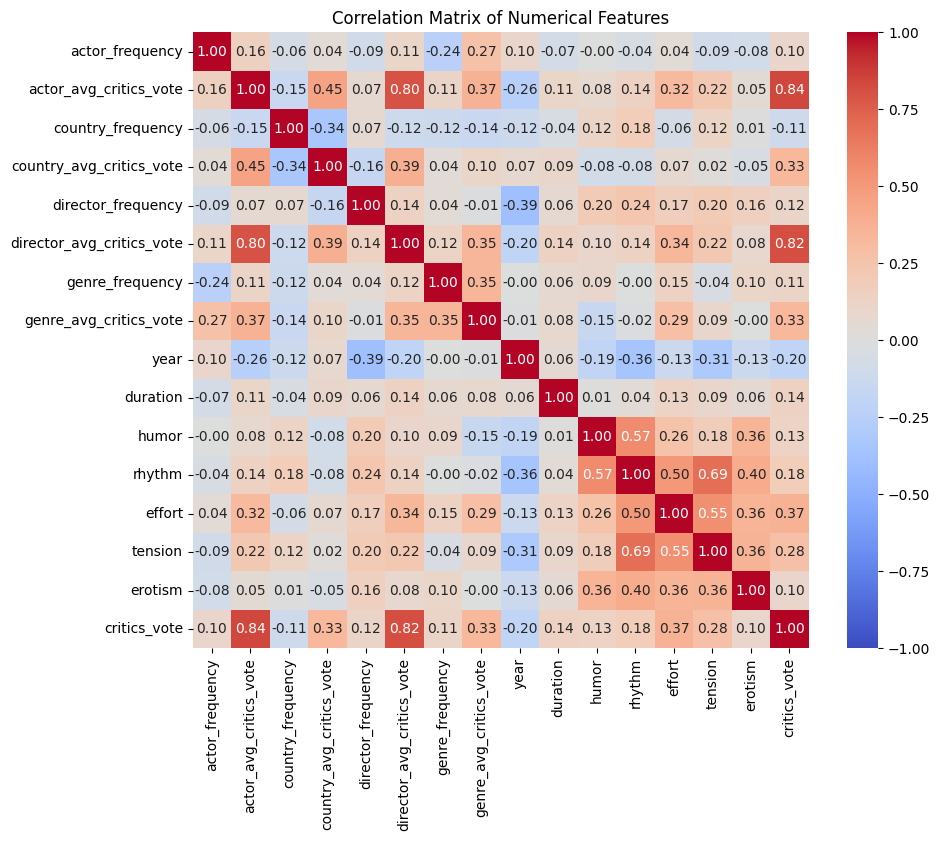

                           actor_frequency  actor_avg_critics_vote  \
actor_frequency                   1.000000                0.155249   
actor_avg_critics_vote            0.155249                1.000000   
country_frequency                -0.055778               -0.146523   
country_avg_critics_vote          0.043721                0.450043   
director_frequency               -0.087421                0.068507   
director_avg_critics_vote         0.106500                0.803373   
genre_frequency                  -0.240238                0.114315   
genre_avg_critics_vote            0.271189                0.370651   
year                              0.097462               -0.255036   
duration                         -0.073572                0.109268   
humor                            -0.002779                0.075652   
rhythm                           -0.039392                0.136209   
effort                            0.043854                0.316288   
tension             

In [60]:
# Select numerical features for correlation analysis
predictor_features = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'genre_frequency', 'genre_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism', 'critics_vote']

# Drop features not in the dataset
numerical_features = [col for col in predictor_features if col in train_data.columns]

# Calculate the correlation matrix
correlation_matrix = train_data[predictor_features].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Print correlation matrix
print(correlation_matrix)

High correlations around 0.80 indicate multicollinearity for actor_avg_critics_vote and director_avg_critics_vote. Also humor, rythm, effort, tension, and erotism have moderate correlations.

### Distribution Analysis

It appears that the newly generated features are consistent between the train-test set based on the distribution below.

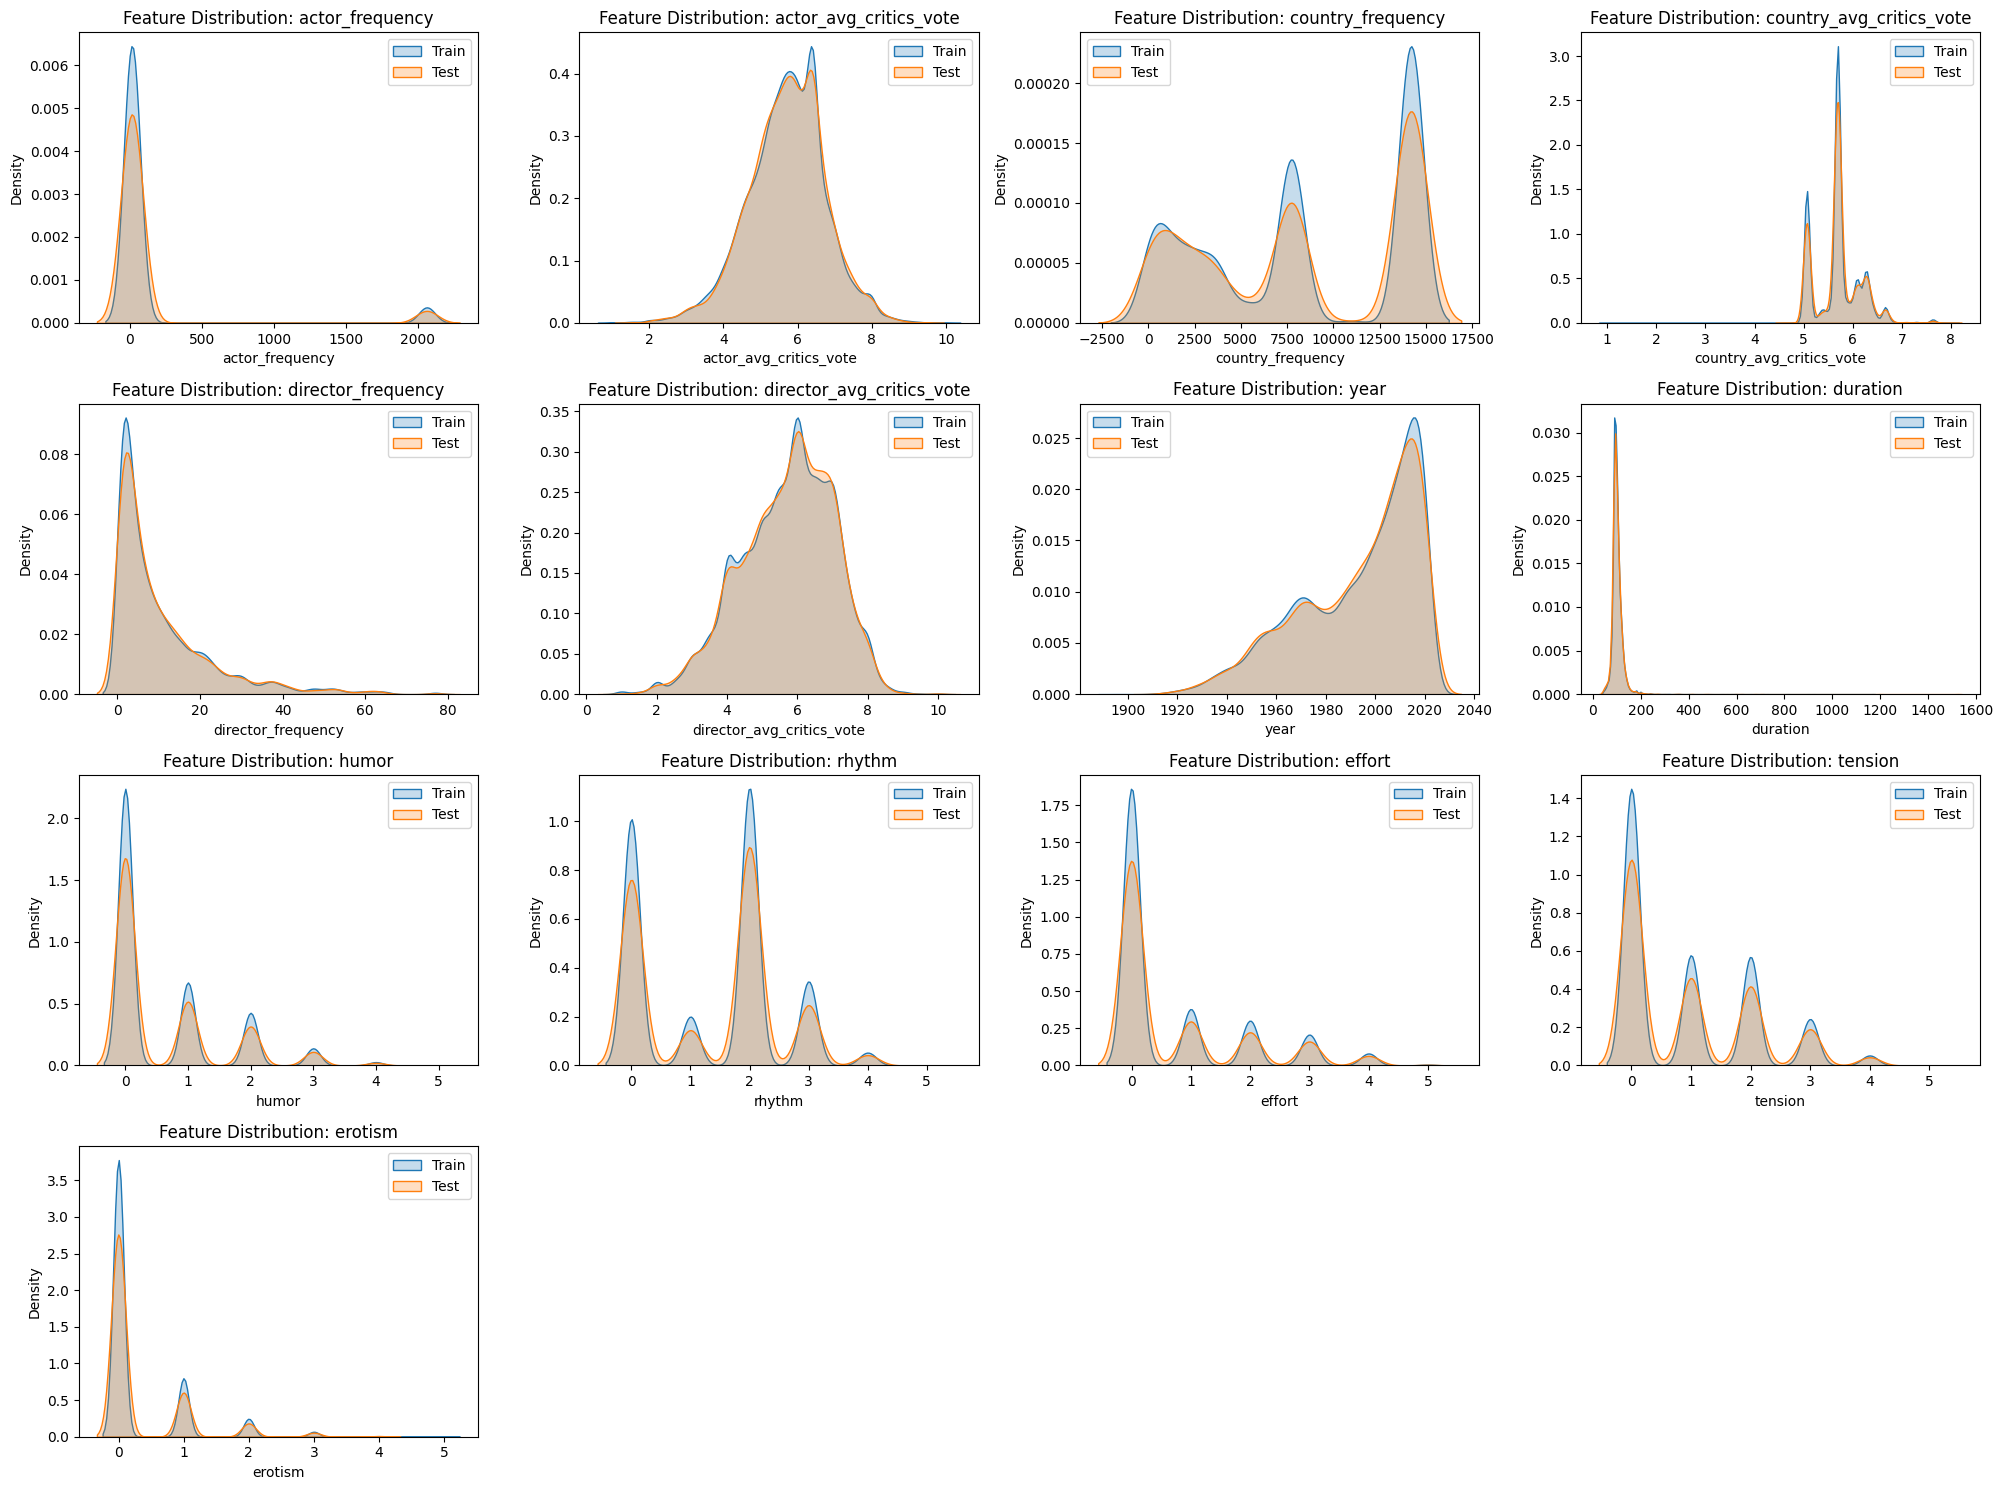

In [61]:
feature_columns = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism']

num_features = len(feature_columns)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(20, 15))

for i, col in enumerate(feature_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.kdeplot(train_data[col], label="Train", shade=True)
    sns.kdeplot(test_data[col], label="Test", shade=True)
    plt.title(f"Feature Distribution: {col}")
    plt.legend()

plt.tight_layout()
plt.show()

## Model Selection

### Managing Multicollinearity
Based on the multicollinearity testing: humor, rythm, effort, tension, and erotism might have high correlation which indicates potential redudancy. actor_avg_critics_vote and director_avg_critics_vote also appear to have high correlation. Further testing is done as part of model selection to manage those variables.

#### F-Test (Univariate Regression)

F-Test computes the F-statistic and p-values for each feature using f_regression, which tests the variance explained by each feature in a univariate regression.

In [62]:
# Select features and target
X = train_data[['humor', 'rhythm', 'effort', 'tension', 'erotism']]
y = train_data['critics_vote']

# Perform F-Test
f_values, p_values = f_regression(X, y)

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
feature_importance = feature_importance.sort_values(by='F-Value', ascending=False)

print(feature_importance)


   Feature      F-Value        P-Value
2   effort  5148.336532   0.000000e+00
3  tension  2688.613373   0.000000e+00
1   rhythm  1080.418327  5.024353e-233
0    humor   556.102687  6.694558e-122
4  erotism   288.646802   1.895468e-64


`effort` and `tension` have the highest F-values, they explain most of the variance in `critics_vote`

In [63]:
# Select features and target
X = train_data[['actor_avg_critics_vote', 'director_avg_critics_vote']]
y = train_data['critics_vote']

# Perform F-Test
f_values, p_values = f_regression(X, y)

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
feature_importance = feature_importance.sort_values(by='F-Value', ascending=False)

print(feature_importance)

                     Feature       F-Value  P-Value
0     actor_avg_critics_vote  76387.248471      0.0
1  director_avg_critics_vote  64820.182536      0.0


The results indicate that all five selected features (effort, tension, rhythm, humor, and erotism) and two new features (actor_avg_critics_vote and director_avg_critics_vote) are highly predictive of critics_vote, as shown by their substantial F-values and extremely low P-values. However, the presence of moderate correlations among these features suggests potential multicollinearity, which can affect the stability and interpretability of GLM model.

#### VIF Test (Variance Inflation Factor)

VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity.

In [64]:
# Select the predictors
selected_features = ['effort', 'tension', 'rhythm', 'humor', 'erotism']
X = train_data[selected_features]

# Add a constant for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   Feature       VIF
0    const  2.382253
1   effort  1.534998
2  tension  2.555483
3   rhythm  3.214208
4    humor  1.816784
5  erotism  1.314497


In [65]:
# Select the predictors
selected_features = ['actor_avg_critics_vote', 'director_avg_critics_vote']
X = train_data[selected_features]

# Add a constant for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     Feature        VIF
0                      const  30.888861
1     actor_avg_critics_vote   2.820145
2  director_avg_critics_vote   2.820145


Interpretation:

VIF < 5: Generally acceptable.  
5 ≤ VIF < 10: Indicates moderate multicollinearity.  
VIF ≥ 10: Indicates high multicollinearity, which is problematic.  

Based on the VIF test above, those variables are not having significant multicollinearity.

### Statistical Feature Selection

#### P-test (Significance Test)

Significance test is done to select only significant features to improve interpretability and maximizing performance if applicable.

In [66]:
feature_columns = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism', 'IS_GENRE_MISSING',
                      'IS_COUNTRY_MISSING', 'IS_DIRECTOR_MISSING',
                      'IS_POPULAR_COUNTRY', 'IS_POPULAR_GENRE']

X = train_data[feature_columns]
y = train_data['critics_vote']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           critics_vote   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     6333.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:08:42   Log-Likelihood:                -35822.
No. Observations:               31624   AIC:                         7.168e+04
Df Residuals:                   31605   BIC:                         7.184e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Based on the p-test above, it is shown that missingness indicators are not statistically significant. Thus, we can remove those to simplify the model. This is expected due to small amount of missingness and it might be completely random (MCAR), thus keeping this indicators didn't add value to the model.
- IS_ACTOR_MISSING
- IS_GENRE_MISSING
- IS_COUNTRY_MISSING
- IS_DIRECTOR_MISSING

In [67]:
feature_columns = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism']

X = train_data[feature_columns]
y = train_data['critics_vote']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           critics_vote   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     8748.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:08:42   Log-Likelihood:                -35853.
No. Observations:               31624   AIC:                         7.173e+04
Df Residuals:                   31610   BIC:                         7.185e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### VIF Test (Variance Inflation Factor)

In [68]:
# Add constant
X_const = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame({
    'Feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print(vif_data)

                      Feature           VIF
0                       const  10908.827182
1             actor_frequency      1.084843
2      actor_avg_critics_vote      3.304530
3           country_frequency      1.206581
4    country_avg_critics_vote      1.494232
5          director_frequency      1.289129
6   director_avg_critics_vote      2.992188
7                        year      1.480428
8                    duration      1.058840
9                       humor      1.849237
10                     rhythm      3.395656
11                     effort      1.770615
12                    tension      2.677732
13                    erotism      1.340190


Based on the VIF Test above, we retain all candidate predictor variables since the VIF are below 5.

**Here, VIF testing confirms no significant multicollinearity among the candidate predictors.**

In [69]:
# Calculate residuals from the OLS model
residuals = model.resid

# Add residuals to the DataFrame for analysis
train_data['residuals'] = residuals

# Display the first few rows to verify
print(train_data[['critics_vote', 'residuals']].head())


   critics_vote  residuals
0      5.374737  -0.428782
1      5.000000  -0.588702
2      6.000000  -0.745387
3      8.000000   1.294836
4      7.480000  -0.299478


- The residuals in vary between -0.745 and 1.294, which suggests there are both underpredictions and overpredictions.
- Most residuals seem small in magnitude, implying the model generally predicts well for these observations.

### Forward Selection

#### GLM 0: Intercept Only

In [70]:
# Intercept-Only OLS Model
glm_0 = sm.GLM.from_formula(
    'critics_vote ~ 1',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

# Display the summary
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries

print(glm_0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           critics_vote   No. Observations:                31624
Model:                            GLM   Df Residuals:                    31623
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          2.5990
Method:                          IRLS   Log-Likelihood:                -59975.
Date:                Thu, 12 Dec 2024   Deviance:                       82189.
Time:                        17:08:42   Pearson chi2:                 8.22e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          5.000e-10
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7111      0.009    629.980      0.0

#### GLM 1: actor_frequency

In [71]:
glm_1 = sm.GLM.from_formula(
    'critics_vote ~ actor_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [72]:
# Display the summary
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant


**The feature actor_frequency is not significant enough to justify inclusion.**

#### GLM 2: actor_avg_critics_vote

In [73]:
glm_2 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [74]:
# Display the summary
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,


**The feature `actor_avg_critics_vote` is a highly significant predictor of `critics_vote` and is therefore retained.**

#### GLM 3: country_frequency

In [75]:
glm_3 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + country_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [76]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant


#### GLM 4: country_avg_critics_vote

In [77]:
glm_4 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + country_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [78]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant


#### GLM 5: director_frequency

In [79]:
glm_5 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [80]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant


#### GLM 6: director_avg_critics_vote

In [81]:
glm_6 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [82]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,


#### GLM 7: year

In [83]:
glm_7 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + year',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [84]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant


#### GLM 8: duration

In [85]:
glm_8 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + duration',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [86]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant


#### GLM 9: humor

In [87]:
glm_9 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + humor',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [88]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 10: rhythm

In [89]:
glm_10 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + rhythm',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [90]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 11: effort

In [91]:
glm_11 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + effort',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [92]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 12: tension

In [93]:
glm_12 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + tension',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [94]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 13: erotism

In [95]:
glm_13 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + erotism',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [96]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 14: genre_frequency

In [97]:
glm_14 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + genre_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [98]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_14, glm_6, "GLM 14", "genre_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 15: genre_avg_critics_vote

In [99]:
glm_15 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + genre_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [100]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_14, glm_6, "GLM 14", "genre_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_15, glm_6, "GLM 15", "genre_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 16: genre

In [101]:
top_10_genres = genre_stats.head(10)['genres_list'].tolist()

train_data_genre = train_data.copy()
test_data_genre = test_data.copy()

for genre in top_10_genres:
    train_data_genre[f'genre_{genre}'] = train_data_genre['genre'].apply(
        lambda x: 1 if genre in x.split(', ') else 0
    )

for genre in top_10_genres:
    test_data_genre[f'genre_{genre}'] = test_data_genre['genre'].apply(
        lambda x: 1 if genre in x.split(', ') else 0
    )

In [102]:
formula = 'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + ' + ' + '.join([f'genre_{genre}' for genre in top_10_genres])
glm_16 = sm.GLM.from_formula(
    formula,
    data=train_data_genre,
    family=sm.families.Gaussian()
).fit()

In [103]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_14, glm_6, "GLM 14", "genre_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_15, glm_6, "GLM 15", "genre_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_16, glm_6, "GLM 16", "genre", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


We are retaining the features `actor_avg_critics_vote` and `director_avg_critics_vote` for the final model, as they contribute significantly to explaining the variance in critics_vote.

### Backward Elimination

#### GLM 6: baseline

In [104]:
glm_backward_summaries = None
glm_backward_summaries = model_summary(glm_6, glm_6, "GLM 6", "Forward Selection", "Accept", "Baseline", glm_backward_summaries)
glm_backward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 6,Forward Selection,74039.456078,-308404.480486,0.780038,0.0,0.00%,Accept,Baseline


#### GLM 17: actor_avg_critics_vote

In [105]:
glm_17 = sm.GLM.from_formula(
    'critics_vote ~ director_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [106]:
glm_backward_summaries = None
glm_backward_summaries = model_summary(glm_6, glm_6, "GLM 6", "Forward Selection", "Accept", "Baseline", glm_backward_summaries)
glm_backward_summaries = model_summary(glm_17, glm_6, "GLM 17", "actor_avg_critics_vote", "Reject", "Signficant", glm_backward_summaries)
glm_backward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 6,Forward Selection,74039.456078,-308404.480486,0.780038,0.000000,0.00%,Accept,Baseline
1,GLM 17,actor_avg_critics_vote,84689.565750,-300708.259299,0.923122,0.143083,18.34%,Reject,Signficant


**`actor_avg_critics_vote` is critical to the model, and removing it reduces performance significantly.**

#### GLM 18: director_avg_critics_vote

In [107]:
glm_18 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [108]:
glm_backward_summaries = None
glm_backward_summaries = model_summary(glm_6, glm_6, "GLM 6", "Forward Selection", "Accept", "Baseline", glm_backward_summaries)
glm_backward_summaries = model_summary(glm_17, glm_6, "GLM 17", "actor_avg_critics_vote", "Reject", "Signficant", glm_backward_summaries)
glm_backward_summaries = model_summary(glm_18, glm_6, "GLM 18", "director_avg_critics_vote", "Reject", "Signficant", glm_backward_summaries)
glm_backward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 6,Forward Selection,74039.456078,-308404.480486,0.780038,0.000000,0.00%,Accept,Baseline
1,GLM 17,actor_avg_critics_vote,84689.565750,-300708.259299,0.923122,0.143083,18.34%,Reject,Signficant
2,GLM 18,director_avg_critics_vote,81107.414916,-303594.265028,0.872292,0.092254,11.83%,Reject,Signficant


**The best model includes both `actor_avg_critics_vote` and `director_avg_critics_vote`.** Both features are significant, and further backward elimination is unnecessary.

## Model Validation

### Cross Validation

In [109]:
# Apply cross-validation to your final model
cv_results = cross_validate_glm(
    formula='critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian(),
    k=5
)

# Display the results
print(f"Mean RMSE: {cv_results['mean_rmse']:.4f}")
print(f"RMSEs for each fold: {cv_results['rmse_scores']}")

Mean RMSE: 0.7801
RMSEs for each fold: [0.7764912066756648, 0.7748258258476282, 0.7882181963873633, 0.7840090841703232, 0.7769403101122208]


**The mean RMSE from the 5-fold cross-validation is very close to the RMSE observed during training (0.7800 from GLM 6), which implies there is no indication of overfitting.**

Based on the CV results, it appears that the model is stable as the variances are small across the folds.

### GLM Final Model

In [110]:
glm_final = glm_6

# Predict on test data
y_test_pred = glm_final.predict(test_data)

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(test_data['critics_vote'], y_test_pred))
print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.7849712313456717


The RMSE on the test data is very close to the mean RMSE from cross-validation (0.7801) and the training RMSE from GLM 6 (0.7800). This consistency assures that the model generalizes well to unseen data.

### Residual Analysis

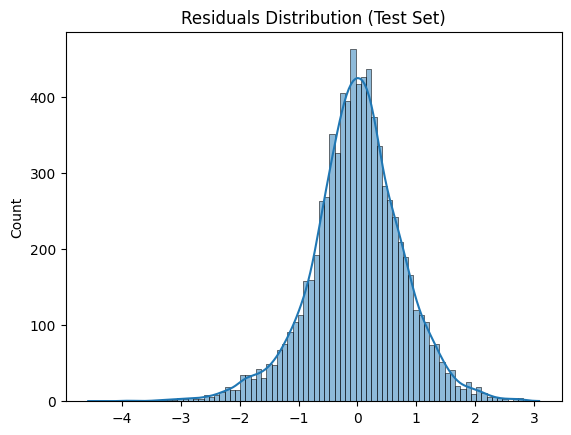

In [111]:
residuals = test_data['critics_vote'] - y_test_pred
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (Test Set)")
plt.show()

The residuals follow a normal distribution. Also, the residuals are symmetrically distributed, with no significant skewness.

### Summary

Based on the forward selection and backward elimination test, the final model for GLM will be GLM 6: 'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote'.

In [112]:
print(glm_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           critics_vote   No. Observations:                31624
Model:                            GLM   Df Residuals:                    31621
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.60852
Method:                          IRLS   Log-Likelihood:                -37017.
Date:                Thu, 12 Dec 2024   Deviance:                       19242.
Time:                        17:08:44   Pearson chi2:                 1.92e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9620
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

- Pseudo R-squared (Cox & Snell): 0.9620 indicates the model explains ~96.2% of the variance in critics_vote, demonstrating strong predictive performance
- The high pseudo R-squared value (0.962) and low deviance (19242) indicate an excellent fit to the data.

## Output

In [113]:
joblib.dump(glm_final, 'OUTPUT/glm_model.pkl', compress=1)
actor_stats.to_csv('OUTPUT/actor_stats.csv')
director_stats.to_csv('OUTPUT/director_stats.csv')